In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
import random
from matplotlib import colormaps as cm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/CCM/labeled_image_list.pkl')
df_test = pd.read_pickle('/content/drive/MyDrive/CCM/test_image_list.pkl')

df['Image'] = df['Image'].apply(lambda x: x[:, :, :3] / 270) # Normalize each image
images = np.stack(df['Image'].values) # (128, 128, 3)

labels = df['label'].values
label_mask = df['label'].notnull()

x_labeled = images[label_mask]
x_unlabeled = images[~label_mask]
y_labeled = labels[label_mask]

df_test["Image"] = df_test['Image'].apply(lambda x: x[:, :, :3] / 270)
x_test = np.stack(df_test['Image'].values)

LE = LabelEncoder()
y_encoded = LE.fit_transform(y_labeled)
y_classes = keras.utils.to_categorical(y_encoded, num_classes= len(LE.classes_))


In [ ]:
# Source: Dr. Haberilie's CNN.ipynb notebook

model = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.2),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(len(LE.classes_), activation="softmax")

    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 126, 126, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,225,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,226,755 (27.57 MB)

 Trainable params: 7,226,755 (27.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 100

model.compile(loss= 'categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

history = model.fit(x_labeled, y_classes, epochs=epochs, batch_size=32, validation_split=0.2)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 720ms/step - accuracy: 0.2688 - loss: 8.3321 - val_accuracy: 0.5769 - val_loss: 7.2387
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5441 - loss: 7.3447 - val_accuracy: 0.5769 - val_loss: 2.7880
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4473 - loss: 2.9094 - val_accuracy: 0.6154 - val_loss: 0.8159
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4897 - loss: 1.2116 - val_accuracy: 0.5769 - val_loss: 1.5389
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6393 - loss: 1.2080 - val_accuracy: 0.7692 - val_loss: 0.7702
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7279 - loss: 0.8149 - val_accuracy: 0.6154 - val_loss: 1.0726
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7660 - loss: 0.6958 - val_accuracy: 0.8077 - val_loss: 0.4631
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8485 - loss: 0.3787 - val_accuracy: 0.7308 - val_loss

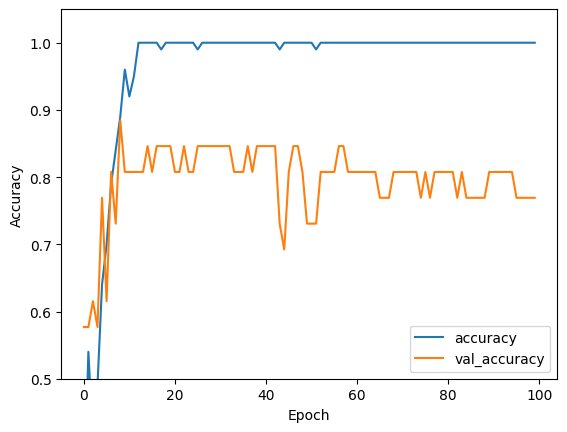

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.05])
plt.legend()
plt.show()

In [ ]:
y_probs_unlabeled = model.predict(x_unlabeled)
y_pred_unlabeled = y_probs_unlabeled.argmax(axis= 1)

df_unlabeled = pd.DataFrame({
    'label': y_pred_unlabeled,
    'Image': [image for image in x_unlabeled]
})

df_unlabeled['label'] = LE.inverse_transform(y_pred_unlabeled)
df_unlabeled['Image'] = df_unlabeled['Image'].apply(lambda x: np.clip(x[:, :, :3] * 270, 0, 255).astype('uint8'))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


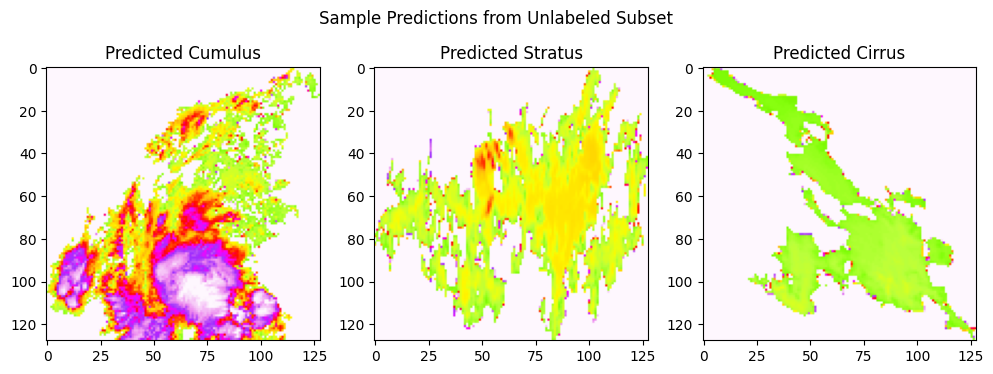

In [ ]:
cmap = cm['gist_ncar_r'].copy() # Colormap
cmap.set_bad(color='gray') # Setting any missing/nan values to gray to make it look nice
vmin = 200
vmax = 320


predicted_cumulus = df_unlabeled[df_unlabeled['label'] == 'Cumulus']
random_cumulus = random.choice(predicted_cumulus.index)
random_cumulus_img = predicted_cumulus.loc[random_cumulus, 'Image']


predicted_stratus = df_unlabeled[df_unlabeled['label'] == 'Stratus']
random_stratus = random.choice(predicted_stratus.index)
random_stratus_img = predicted_stratus.loc[random_stratus, 'Image']

predicted_cirrus = df_unlabeled[df_unlabeled['label'] == 'Cirrus']
random_cirrus = random.choice(predicted_cirrus.index)
random_cirrus_img = predicted_cirrus.loc[random_cirrus, 'Image']

fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(random_cumulus_img, cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title('Predicted Cumulus')

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(random_stratus_img, cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title('Predicted Stratus')

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(random_cirrus_img, cmap=cmap, vmin=vmin, vmax=vmax)
ax3.set_title('Predicted Cirrus')

plt.suptitle('Sample Predictions from Unlabeled Subset')

plt.show()



In [ ]:
df_unlabeled['label'].value_counts()

,count
label,
Cumulus,688
Stratus,224
Cirrus,9


In [ ]:
y_probs = model.predict(x_test)
y_pred = y_probs.argmax(axis= 1)

df_test['label'] = LE.inverse_transform(y_pred)
df_test['Image'] = df_test['Image'].apply(lambda x: np.clip(x[:, :, :3] * 270, 0, 255).astype('uint8'))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


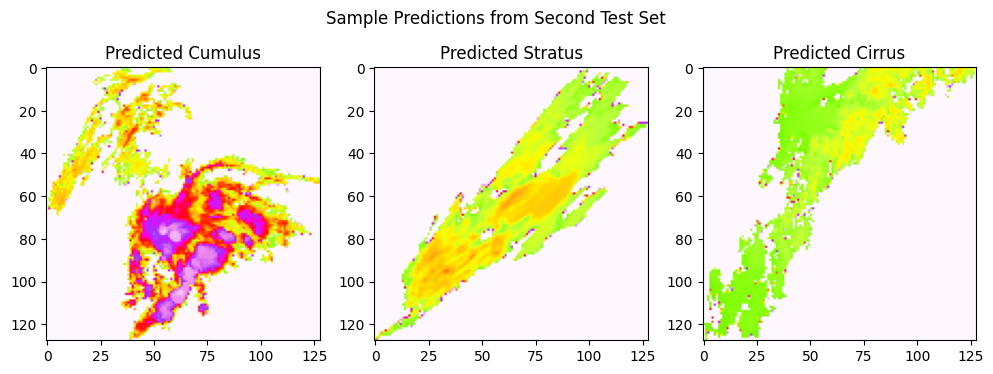

In [ ]:
cmap = cm['gist_ncar_r'].copy() # Colormap
cmap.set_bad(color='gray') # Setting any missing/nan values to gray to make it look nice
vmin = 200
vmax = 320


predicted_cumulus = df_test[df_test['label'] == 'Cumulus']
random_cumulus = random.choice(predicted_cumulus.index)
random_cumulus_img = predicted_cumulus.loc[random_cumulus, 'Image']


predicted_stratus = df_test[df_test['label'] == 'Stratus']
random_stratus = random.choice(predicted_stratus.index)
random_stratus_img = predicted_stratus.loc[random_stratus, 'Image']

predicted_cirrus = df_test[df_test['label'] == 'Cirrus']
random_cirrus = random.choice(predicted_cirrus.index)
random_cirrus_img = predicted_cirrus.loc[random_cirrus, 'Image']

fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(random_cumulus_img, cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title('Predicted Cumulus')

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(random_stratus_img, cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title('Predicted Stratus')

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(random_cirrus_img, cmap=cmap, vmin=vmin, vmax=vmax)
ax3.set_title('Predicted Cirrus')

plt.suptitle('Sample Predictions from Second Test Set')

plt.show()

In [ ]:
df_test['label'].value_counts()

,count
label,
Cumulus,343
Stratus,125
Cirrus,6


In [ ]:
confidence = y_probs_unlabeled.max(axis= 1)
df_unlabeled['confidence'] = confidence


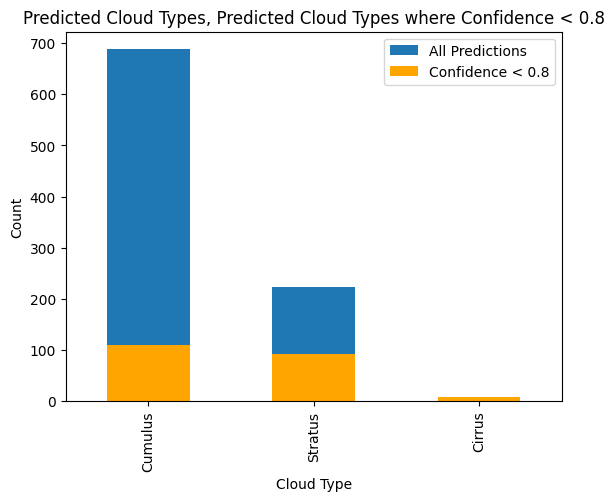

In [ ]:
df_unlabeled['label'].value_counts().plot.bar(title= 'Predicted Cloud Types, Predicted Cloud Types where Confidence < 0.8', label= 'All Predictions')
df_unlabeled[df_unlabeled['confidence'] < 0.8]['label'].value_counts().plot.bar(color= 'orange', label = 'Confidence < 0.8')
plt.legend()
plt.xlabel('Cloud Type')
plt.ylabel('Count')
plt.show()

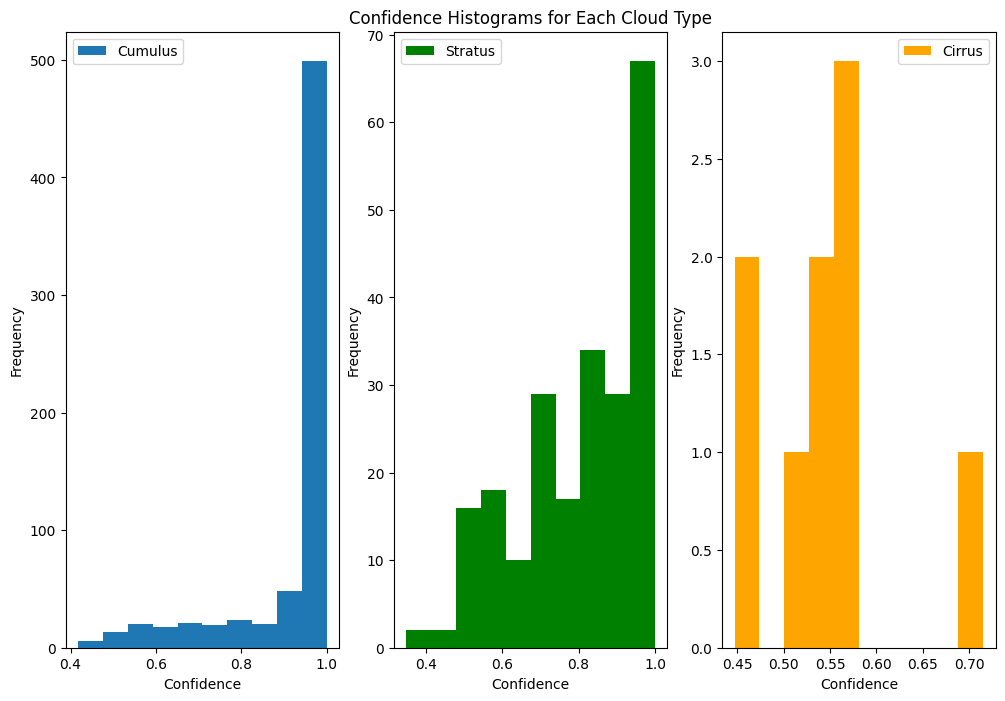

In [ ]:
fig, ax = plt.subplots(1, 3, figsize= (12, 8))
ax = ax.flatten()

df_unlabeled[df_unlabeled['label'] == 'Cumulus']['confidence'].plot.hist(ax= ax[0], label= 'Cumulus')
df_unlabeled[df_unlabeled['label'] == 'Stratus']['confidence'].plot.hist(ax= ax[1], label= 'Stratus', color= 'green')
df_unlabeled[df_unlabeled['label'] == 'Cirrus']['confidence'].plot.hist(ax= ax[2], label= 'Cirrus', color= 'orange')

ax[1].set_title('Confidence Histograms for Each Cloud Type Prediction')

for i in range(3):
  ax[i].set_xlabel('Confidence')
  ax[i].legend()
plt.show()

<ipython-input-31-470781231a34>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test[df_unlabeled['label'] == 'Cumulus']['confidence'].plot.hist(ax= ax[0], label= 'Cumulus')
<ipython-input-31-470781231a34>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test[df_unlabeled['label'] == 'Stratus']['confidence'].plot.hist(ax= ax[1], label= 'Stratus', color= 'green')
<ipython-input-31-470781231a34>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test[df_unlabeled['label'] == 'Cirrus']['confidence'].plot.hist(ax= ax[2], label= 'Cirrus', color= 'orange')


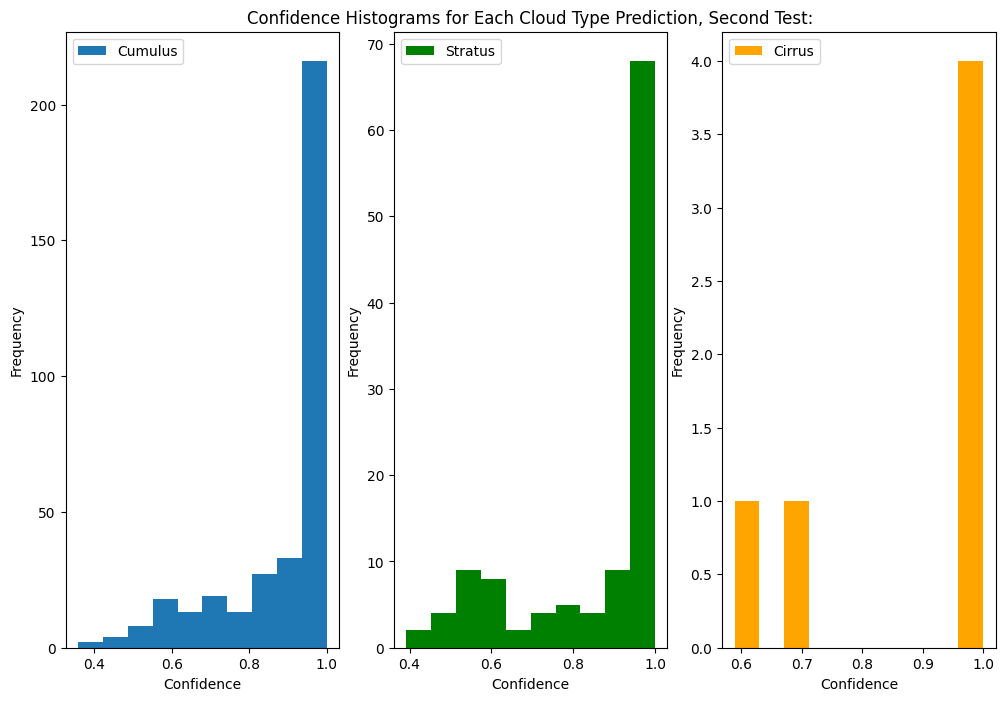

In [ ]:
confidence2 = y_probs.max(axis= 1)
df_test['confidence'] = confidence2

fig, ax = plt.subplots(1, 3, figsize= (12, 8))
ax = ax.flatten()

df_test[df_unlabeled['label'] == 'Cumulus']['confidence'].plot.hist(ax= ax[0], label= 'Cumulus')
df_test[df_unlabeled['label'] == 'Stratus']['confidence'].plot.hist(ax= ax[1], label= 'Stratus', color= 'green')
df_test[df_unlabeled['label'] == 'Cirrus']['confidence'].plot.hist(ax= ax[2], label= 'Cirrus', color= 'orange')

ax[1].set_title('Confidence Histograms for Each Cloud Type Prediction, Second Test:')

for i in range(3):
  ax[i].set_xlabel('Confidence')
  ax[i].legend()
plt.show()

In [ ]:
df_unlabeled['label'].value_counts()

,count
label,
Cumulus,688
Stratus,224
Cirrus,9


In [ ]:
df_test['label'].value_counts()


,count
label,
Cumulus,343
Stratus,125
Cirrus,6
